In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [84]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      if num_sentences == 0:
        print(type(row[0]))
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
      list_item=[row[5], 0 if row[0] == '0' else 1]
      # YOUR CODE HERE
      num_sentences = num_sentences + 1
      corpus.append(list_item)


--2020-04-08 19:06:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  74.6MB/s    in 3.1s    

2020-04-08 19:06:10 (74.6 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]

<class 'str'>


In [85]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [86]:
print(type(corpus[0]))
print(corpus[1])

<class 'list'>
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:]

In [88]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138320
1


In [89]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-04-08 19:06:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  98.6MB/s    in 3.4s    

2020-04-08 19:07:02 (98.6 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [90]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138321


In [91]:
dropout = 0.1

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False, name='Embedding'),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(dropout, name='Dropout1'),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), name='Bidirectional1'),
    tf.keras.layers.LSTM(32, return_sequences=True, name='LSTM1'),
    tf.keras.layers.Dropout(dropout, name='Dropout2'),
    tf.keras.layers.LSTM(32, return_sequences=True, name='LSTM2'),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), name='Bidirectional2'),
    tf.keras.layers.Dropout(dropout, name='Dropout3'),
    # tf.keras.layers.LSTM(32, return_sequences=True, name='LSTM3'),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), name='Bidirectional3'),
    # tf.keras.layers.Dropout(dropout, name='Dropout4'),
    tf.keras.layers.Conv1D(128, 5, activation='relu', name='Conv1'),
    # tf.keras.layers.Dropout(dropout, name='Dropout5'),
    # tf.keras.layers.GlobalAveragePooling1D(name='Pooling1'),

    tf.keras.layers.Conv1D(128, 5, activation='relu', name='Conv2'),
    tf.keras.layers.Dropout(dropout, name='Dropout6'),
    # tf.keras.layers.GlobalAveragePooling1D(name='Pooling2'),
    tf.keras.layers.MaxPooling1D(pool_size=4, name='MaxPooling1'),

    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu', name='Dense1'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='Dense2')


])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 16, 100)           13832100  
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 100)           0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 16, 32)            17024     
_________________________________________________________________
Dropout2 (Dropout)           (None, 16, 32)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 16, 32)            8320      
_________________________________________________________________
Dropout3 (Dropout)           (None, 16, 32)            0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 12, 128)         

<Figure size 432x288 with 0 Axes>

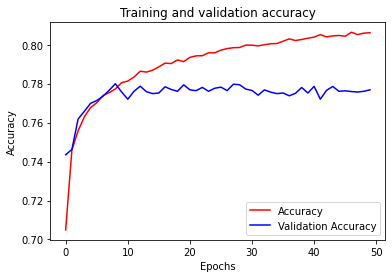

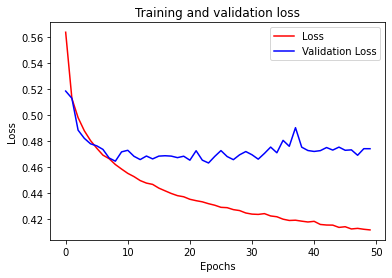

<Figure size 432x288 with 0 Axes>

In [92]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!